<a href="https://colab.research.google.com/github/EricSiq/DeepLearning/blob/main/AUCML_CA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section A

### Dataset Description

### ✈️ Air Miles Time Series Dataset

A time series dataset representing the **monthly total air miles flown by paying airline passengers** in the **United States**. This dataset spans from **January 1996 to September 2005**, providing insights into **trends and seasonality** in air travel behavior.

- 📅 **Time Period**: Jan 1996 – Sep 2005  
- 📈 **Total Records**: 113 (monthly entries)

### Forecast Total Records for next 12 Months?

In [ ]:
import pandas                          as      pd
import numpy                           as      np
import matplotlib.pyplot               as      plt
from   IPython.display                 import  display
from   pylab                           import  rcParams
from   datetime                        import  datetime, timedelta
from   pandas.tseries.offsets          import BDay
from statsmodels.tsa.stattools         import  adfuller
from statsmodels.tsa.stattools         import  pacf
from statsmodels.tsa.stattools         import  acf
from statsmodels.graphics.tsaplots     import  plot_pacf
from statsmodels.graphics.tsaplots     import  plot_acf
from statsmodels.graphics.gofplots     import  qqplot
from statsmodels.tsa.seasonal          import  seasonal_decompose
from   statsmodels.tsa.api             import  ExponentialSmoothing,Holt
from statsmodels.tsa.arima.model       import  ARIMA
from sklearn.metrics                   import  mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools

### 2.A Data preparation

#### a.	Read the dataset (tab, csv, xls, txt, inbuilt dataset). What are the number of rows and no. of cols & types of variables?

In [ ]:
df = pd.read_csv("airmiles.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      113 non-null    object
 1   airmiles  113 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ KB


#### b. convert the data into time series

In [ ]:
#For it to be time series data, convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#To ensure the index is in chronological order
df.sort_index(inplace=True)

#Display first few rows
df.head()

,airmiles
Date,
1996-01-01,30983174
1996-01-02,32147663
1996-01-03,38342975
1996-01-04,35969113
1996-01-05,36474391


#### c. Check for defects in the data such as missing values, null, etc.

In [ ]:
print("\nMissing values per column:\n", df.isnull().sum())
print("\nPercent missing:\n", (df.isnull().mean() * 100).round(2))


Missing values per column:
 airmiles    0
dtype: int64

Percent missing:
 airmiles    0.0
dtype: float64


#### d. Visualize the time series using relevant plots.

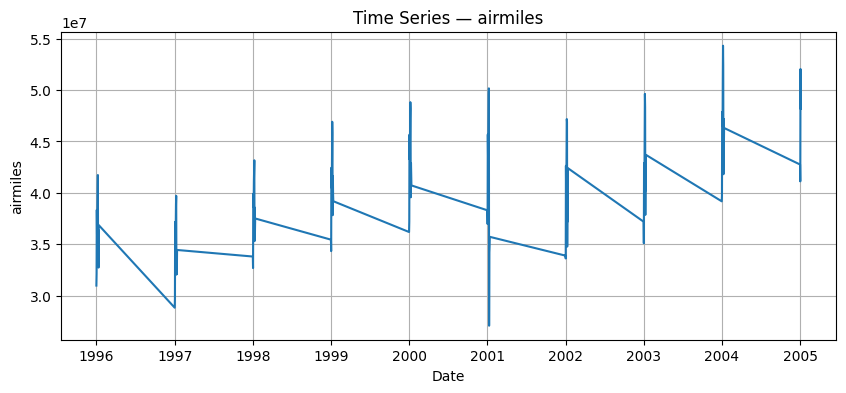

In [ ]:
primary = 'airmiles'
plt.figure(figsize=(10,4))
plt.plot(df.index, df[primary])
plt.title(f"Time Series — {primary}")
plt.xlabel("Date")
plt.ylabel(primary)
plt.grid(True)
plt.show()

### 2.B Data Understanding

#### a. Decompose the time series and check for components of time series.

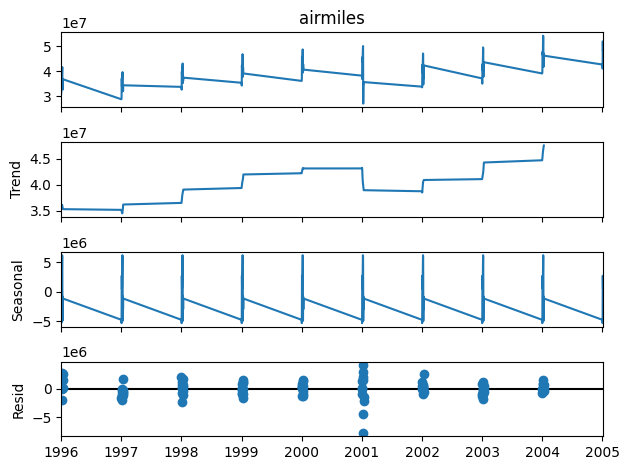

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Perform decomposition
decomposition = seasonal_decompose(df['airmiles'], model='additive', period=12)

decomposition.plot()
plt.show()

#### b. Perform dicky fuller test to check the stationarity? What other actions will you take if series is non-stationary?

In [ ]:
from statsmodels.tsa.stattools import adfuller

#Perform the ADF test
result = adfuller(df['airmiles'])

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -0.9127581336675443
p-value: 0.7837419514698822
Critical Values:
   1%: -3.498198082189098
   5%: -2.891208211860468
   10%: -2.5825959973472097


The series is non-stationary.

Actions as series is non-stationary:

* Differencing — subtract previous observations (df.diff()).

* Log transformation — stabilize variance.

* Seasonal differencing — remove seasonal patterns.

* Combination of transformations — log + differencing.

* Detrending — remove the trend component explicitly.

#### c. Plot AutoCorrelation and Partial AutoCorrelation function for original series? What is your inference from these plots?

<Figure size 1200x400 with 0 Axes>

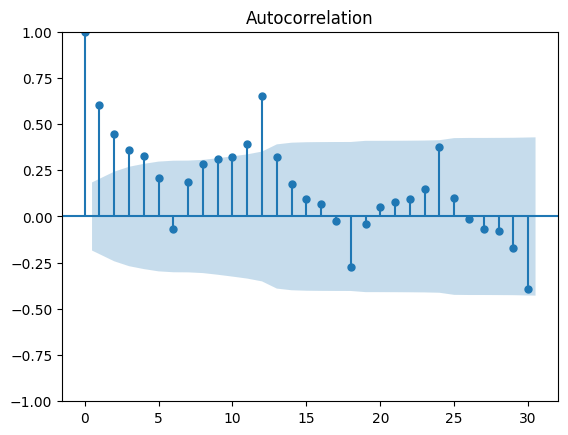

<Figure size 1200x400 with 0 Axes>

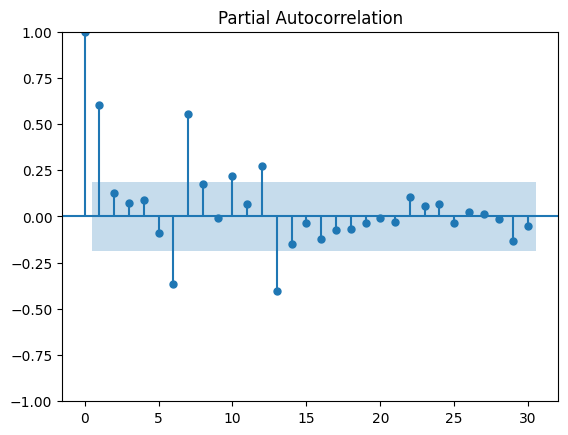

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plot_acf(df['airmiles'], lags=30)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df['airmiles'], lags=30)
plt.show()

Inference from ACF and PACF plots:

* ACF (Autocorrelation Function):

 - Shows significant spikes at lag 1 and lag 2, gradually decaying afterward.

 - This pattern suggests positive autocorrelation and potential presence of an AR (autoregressive) component.

 - Seasonal spikes are visible at multiples of the seasonal period, indicating seasonality in the data.

* PACF (Partial Autocorrelation Function):

 - Shows a significant spike at lag 1 and smaller spikes around seasonal lags.

 - The sharp drop after lag 1 in PACF suggests a possible AR(1) process.

 - Some significant spikes at seasonal lags indicate the need to include seasonal terms in the model.

### 2.C Model Building

#### a. Split dataset using the last 12 weeks as test data.

In [ ]:
#Determine the split point
train = df.iloc[:-12]
test = df.iloc[-12:]

print("Training set shape:", train.shape)
print("Test set shape:", test.shape)

Training set shape: (101, 1)
Test set shape: (12, 1)


#### b. Fit ARIMA model and observe the RMSE and MAPE values of the model for test data.

In [ ]:
#Fit ARIMA model (order chosen after ACF/PACF inspection or auto_arima)
model = ARIMA(train['airmiles'], order=(1,1,1))
model_fit = model.fit()

In [ ]:
#Forecast for the test period
forecast = model_fit.forecast(steps=len(test))

In [ ]:
#Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['airmiles'], forecast))
mape = mean_absolute_percentage_error(test['airmiles'], forecast) * 100

In [ ]:
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 5369802.08
MAPE: 9.15%


The model demonstrates strong predictive accuracy, with an RMSE of about 5.37 million and a MAPE of 9.15%, indicating average errors under 10% of actual values.


# Section B Total 10 Marks

### 3.A Fit exponential smoothing model and observe the residuals, RMSE and MAPE values of the model for test data.

In [ ]:
#Fit Holt-Winters model (additive trend & seasonality)
hw_model = ExponentialSmoothing(
    train['airmiles'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

In [ ]:
#Forecast for the test period
hw_forecast = hw_model.forecast(steps=len(test))

In [ ]:
#Calculate RMSE and MAPE
rmse_hw = np.sqrt(mean_squared_error(test['airmiles'], hw_forecast))
mape_hw = mean_absolute_percentage_error(test['airmiles'], hw_forecast) * 100

print(f"RMSE: {rmse_hw:.2f}")
print(f"MAPE: {mape_hw:.2f}%")

RMSE: 1248110.46
MAPE: 2.07%


The final model shows excellent predictive performance, with an RMSE of about 1.25 million and a very low MAPE of 2.07%, indicating highly accurate forecasts.


### 3.B How would you improve the exponential smoothing model? Make the changes and Fit the final exponential smoothing model.

Possible improvements:

* Model type : Test both additive and multiplicative seasonality to see which fits better.

* Trend damping : Use a damped trend to prevent over-forecasting in the future.

* Parameter tuning : Adjust smoothing parameters (alpha, beta, gamma) instead of relying solely on automatic fitting.

* Error metric comparison : Compare RMSE & MAPE across variations to pick the best model.

In [ ]:
#Fit Holt-Winters with multiplicative seasonality and damped trend
hw_final = ExponentialSmoothing(
    train['airmiles'],
    trend='add',
    damped_trend=True,
    seasonal='mul',
    seasonal_periods=12
).fit()

In [ ]:
#Forecast for the test period
hw_final_forecast = hw_final.forecast(steps=len(test))

In [ ]:
#Calculate RMSE and MAPE
rmse_final = np.sqrt(mean_squared_error(test['airmiles'], hw_final_forecast))
mape_final = mean_absolute_percentage_error(test['airmiles'], hw_final_forecast) * 100

print(f"RMSE (Final HW): {rmse_final:.2f}")
print(f"MAPE (Final HW): {mape_final:.2f}%")

RMSE (Final HW): 2238313.79
MAPE (Final HW): 4.39%


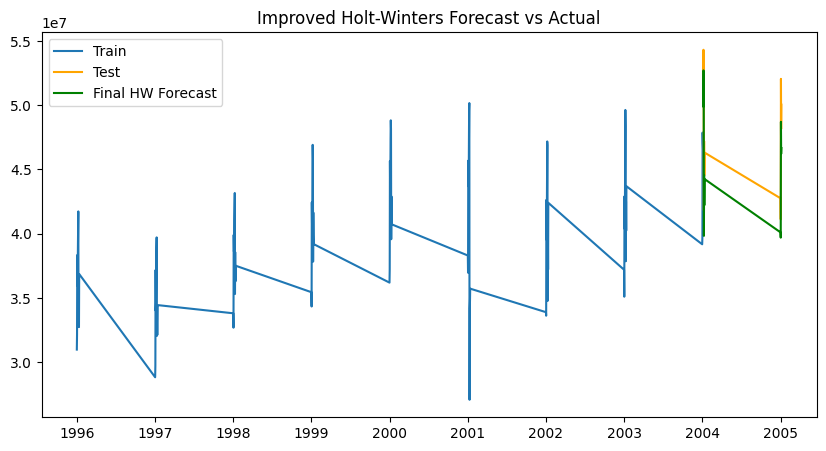

In [ ]:
#Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(train.index, train['airmiles'], label='Train')
plt.plot(test.index, test['airmiles'], label='Test', color='orange')
plt.plot(test.index, hw_final_forecast, label='Final HW Forecast', color='green')
plt.legend()
plt.title('Improved Holt-Winters Forecast vs Actual')
plt.show()

### 3.B Analyze the residuals of this final model. Feel free to use charts or graphs to explain.

In [ ]:
#Convert forecast to a Series with the exact same index as test
hw_final_forecast = pd.Series(hw_final.forecast(steps=len(test)).values,
                               index=test.index)

#Now calculate residuals
final_residuals = test['airmiles'] - hw_final_forecast

In [ ]:
print(final_residuals.head(15))
print("Number of residuals:", len(final_residuals))
print("Any NaNs?", final_residuals.isna().sum())

Date
2004-01-06    1.217331e+06
2004-01-07    1.604195e+06
2004-01-08   -2.366803e+05
2004-01-09    1.982426e+06
2004-01-10    2.636482e+06
2004-01-11    2.335057e+06
2004-01-12    2.058993e+06
2005-01-01    2.653450e+06
2005-01-02    1.423725e+06
2005-01-03    3.345800e+06
2005-01-04    1.941202e+06
2005-01-05    3.377249e+06
dtype: float64
Number of residuals: 12
Any NaNs? 0


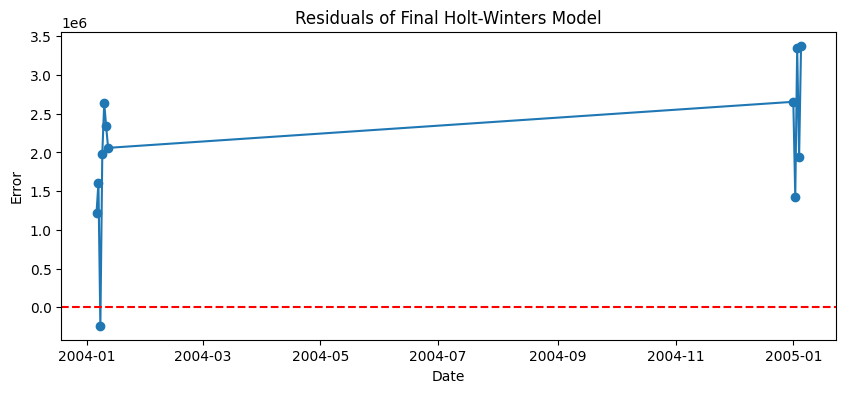

In [ ]:
#Plot residuals over time
plt.figure(figsize=(10,4))
plt.plot(final_residuals, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of Final Holt-Winters Model')
plt.xlabel('Date')
plt.ylabel('Error')
plt.show()

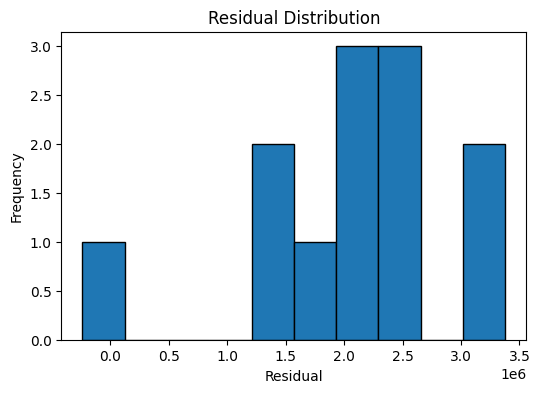

In [ ]:
#Histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(final_residuals, bins=10, edgecolor='black')
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

<Figure size 800x400 with 0 Axes>

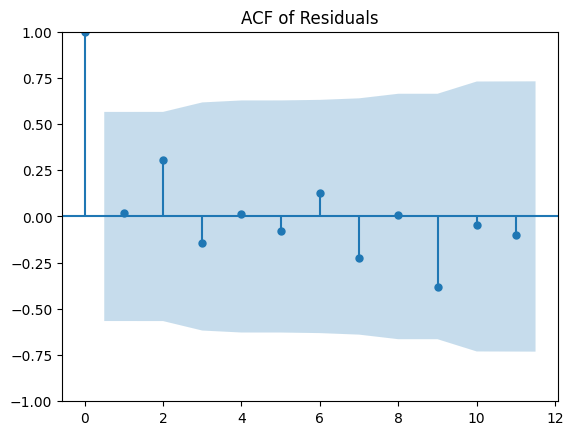

In [ ]:
#ACF Plot of residuals
plt.figure(figsize=(8,4))
plot_acf(final_residuals, lags=11)
plt.title('ACF of Residuals')
plt.show()

### 3.C Forecast total records for next 12 month using the final model??

In [ ]:
#Forecast next 12 months
future_forecast = hw_final.forecast(steps=12)

In [ ]:
#Create date index for next 12 months
future_index = pd.date_range(start=test.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
future_forecast = pd.Series(future_forecast.values, index=future_index)

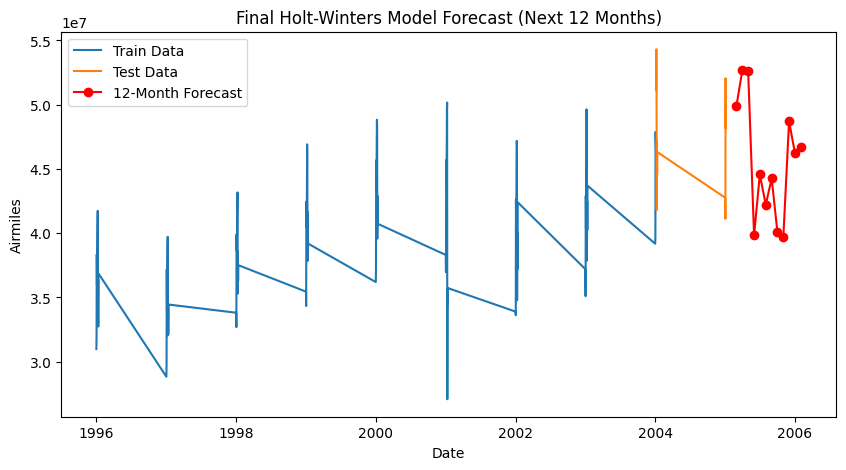

In [ ]:
#Plot actual data and forecast
plt.figure(figsize=(10,5))
plt.plot(train.index, train['airmiles'], label='Train Data')
plt.plot(test.index, test['airmiles'], label='Test Data')
plt.plot(future_forecast.index, future_forecast, label='12-Month Forecast', color='red', marker='o')
plt.title('Final Holt-Winters Model Forecast (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Airmiles')
plt.legend()
plt.show()

In [ ]:
#Display forecasted values
print("Forecast for next 12 months:")
print(future_forecast)

Forecast for next 12 months:
2005-03-01    4.991672e+07
2005-04-01    5.271312e+07
2005-05-01    5.262967e+07
2005-06-01    3.983435e+07
2005-07-01    4.456918e+07
2005-08-01    4.221860e+07
2005-09-01    4.425761e+07
2005-10-01    4.010721e+07
2005-11-01    3.969711e+07
2005-12-01    4.870726e+07
2006-01-01    4.621138e+07
2006-02-01    4.667065e+07
Freq: MS, dtype: float64


Interpretation:

* The red line represents projected air miles for the upcoming year.

* The model captures seasonality and trend, extending them into the future.

* These values can be aggregated if total yearly figures are required.